In [1]:
import warnings
warnings.filterwarnings('ignore')

# turn on plotting
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import num2date
import matplotlib.dates as mdates
#utilities for interacting with the OS
import os
import glob
import datetime
import netCDF4
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
"""
pyart.retrieve.quasi_vertical_profile
=====================================

Retrieval of QVPs from a radar object

.. autosummary::
    :toctree: generated/

    quasi_vertical_profile

"""

import numpy as np

from pyart.io import read
from pyart.core import antenna_to_cartesian



def quasi_vertical_profile(radar, fields = None):
    
    """
    Quasi Vertical Profile.
    
    Creates a QVP object ....
    
    
    Parameters
    ----------
    radar : Radar
        Radar object used.
    field : string
        Radar field to use for QVP calculation.
    
    Other Parameters
    ----------------
    gatefilter : GateFilter
        A GateFilter indicating radar gates that should be excluded
        from the import qvp calculation
        
    Returns
    -------
    qvp : Dictonary
        Dictonary containing fields from radar object
    
    
    
    References
    ----------
    Troemel, S., M. Kumjian, A. Ryzhkov, and C. Simmer, 2013: Backscatter 
    differential phase – estimation and variability. J. Appl. Meteor. Clim.. 
    52, 2529 – 2548.

    Troemel, S., A. Ryzhkov, P. Zhang, and C. Simmer, 2014: Investigations 
    of backscatter differential phase in the melting layer. J. Appl. Meteorol. 
    Clim. 53, 2344 – 2359.

    Ryzhkov, A., P. Zhang, H. Reeves, M. Kumjian, T. Tschallener, S. Troemel, 
    C. Simmer, 2015: Quasi-vertical profiles – a new way to look at polarimetric 
    radar data. Submitted to J. Atmos. Oceanic Technol.
    
    """
    
    qvp = {}
    desired_angle = 20.0
    index = abs(radar.fixed_angle['data'] - desired_angle).argmin()
    print(radar.fixed_angle['data'])
    print(radar.elevation['data'][-1])
    
    if fields is None:
        fields = radar.fields

        for field in fields:
            this_field = radar.get_field(index, field).mean(axis = 0)
            qvp.update({field:this_field})

    else:
        this_field = radar.get_field(index, fields).mean(axis = 0) 
        qvp.update({fields:this_field})
        
    qvp.update({'range': radar.range['data'], 'time': radar.time})
    x,y,z = antenna_to_cartesian(qvp['range']/1000.0, 0.0, 
                                            radar.fixed_angle['data'][index])
    qvp.update({'height': z})
    del radar
    return qvp

In [3]:
files = glob.glob('/lcrc/group/earthscience/radar/xsapr_sgp/vads/20171004/*')
files.sort()

In [5]:
total_power = []
reflectivity = []
velocity = []
spectrum_width = []
differential_reflectivity = []
specific_differential_phase = []
cross_correlation_ratio = []
differential_phase = []
normalized_coherent_power = []
qtime = []
#height = []
rang = []

for file in files:

    radar = pyart.io.read(file)
    radar_start_date = netCDF4.num2date(radar.time['data'][0], 
                                        radar.time['units'])
    time = datetime.datetime.strftime(radar_start_date, '%Y-%m-%dT%H:%M:%S')
    date = datetime.datetime.strftime(radar_start_date, '%Y%m%d')
    
    qvp = quasi_vertical_profile(radar)
    
    tp = qvp['total_power']
    ref = qvp['reflectivity']
    vel = qvp['velocity']
    sw = qvp['spectrum_width']
    dr = qvp['differential_reflectivity']
    kdp = qvp['specific_differential_phase']
    phv = qvp['cross_correlation_ratio']
    dp = qvp['differential_phase']
    ncp = qvp['normalized_coherent_power']
    #qtime = qvp['time']
    hght = qvp['height']
    ran = qvp['range']
    
    total_power.append(tp)
    reflectivity.append(ref)
    velocity.append(vel)
    spectrum_width.append(sw)
    differential_reflectivity.append(dr)
    specific_differential_phase.append(kdp)
    cross_correlation_ratio.append(phv)
    differential_phase.append(dp)
    normalized_coherent_power.append(ncp)
    qtime.append(time)
    #height.append(hght)
    rang.append(ran)
    
    del radar 
    del qvp
    
new_tp = np.array(total_power)
new_ref = np.array(reflectivity)
new_vel = np.array(velocity)
new_sq = np.array(spectrum_width)
new_dr = np.array(differential_reflectivity)
new_kdp = np.array(specific_differential_phase)
new_phv = np.array(cross_correlation_ratio)
new_dp = np.array(differential_phase)
new_ncp = np.array(normalized_coherent_power)
new_time = np.array(qtime, dtype='datetime64[ns]')
#new_height = np.array(height)
new_height = hght
new_range = np.array(rang)

[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.963375
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.94415
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.94689
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8

[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.908447
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.913937
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.93042
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    

[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.941402
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.941402
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.93042
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    

[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.933167
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.93042
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.93591
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8

[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.93591
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.93591
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.94689
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.

[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.92492
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.93042
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.952393
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8

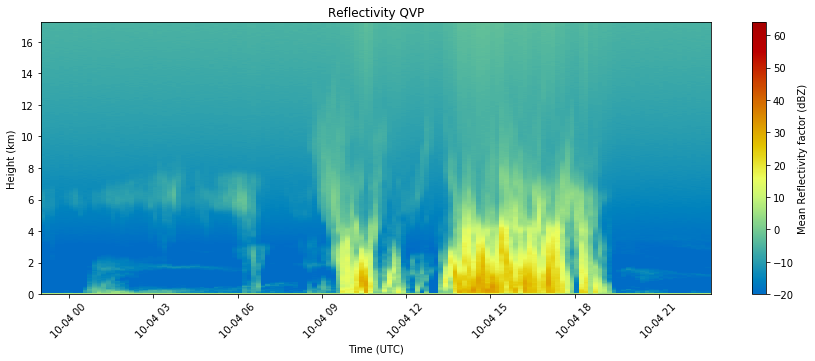

In [7]:
fig = plt.figure(figsize=[15,5])
ax = plt.gca()
#ax.xaxis_date()
cmap = pyart.graph.cm_colorblind.HomeyerRainbow
#for i in range(10):
    #Xq, Yq = np.meshgrid(new_time[i], new_height/1000)
    
    
img = plt.pcolormesh(new_time, new_height/1000, new_ref.transpose(), 
                     cmap=cmap, vmin=-20, vmax=64)
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
#plt.ylim([0,17.5])
plt.xticks(rotation=45)
plt.title('Reflectivity QVP')
cb = plt.colorbar(img, cmap=cmap)
cb.set_label('Mean Reflectivity factor (dBZ)')
#plt.savefig('reflectivity.png', dpi=300)
plt.show()

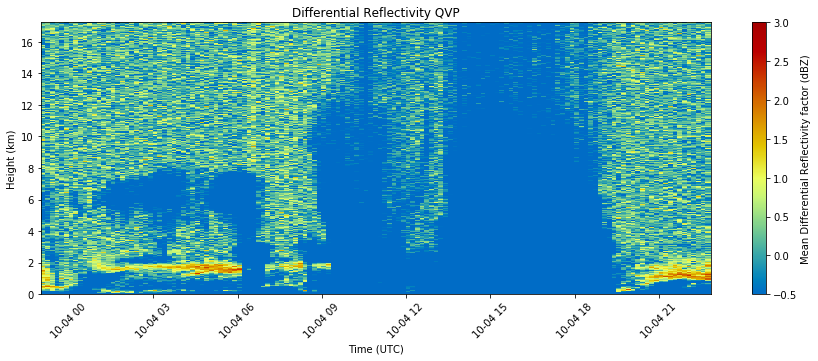

In [9]:
fig = plt.figure(figsize=[15,5])
ax = plt.gca()
#ax.xaxis_date()
cmap = pyart.graph.cm_colorblind.HomeyerRainbow
#for i in range(10):
    #Xq, Yq = np.meshgrid(new_time[i], new_height/1000)
    
    
img = plt.pcolormesh(new_time, new_height/1000, new_dr.transpose(), 
                     cmap=cmap, vmin=-0.5, vmax=3)
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
#plt.ylim([0,17.5])
plt.xticks(rotation=45)
plt.title('Differential Reflectivity QVP')
cb = plt.colorbar(img, cmap=cmap)
cb.set_label('Mean Differential Reflectivity factor (dBZ)')
#plt.savefig('reflectivity.png', dpi=300)
plt.show()

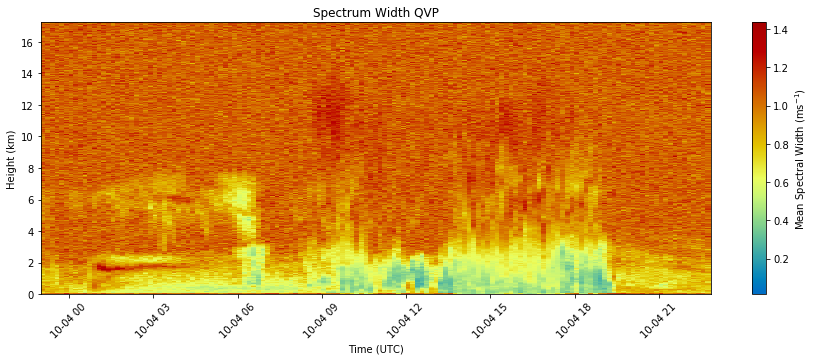

In [12]:
fig = plt.figure(figsize=[15,5])
ax = plt.gca()
#ax.xaxis_date()
cmap = pyart.graph.cm_colorblind.HomeyerRainbow
#for i in range(10):
    #Xq, Yq = np.meshgrid(new_time[i], new_height/1000)
    
    
img = plt.pcolormesh(new_time, new_height/1000, new_sq.transpose(), 
                     cmap=cmap)#, vmin=-0.5, vmax=3)
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
#plt.ylim([0,17.5])
plt.xticks(rotation=45)
plt.title('Spectrum Width QVP')
cb = plt.colorbar(img, cmap=cmap)
cb.set_label('Mean Spectral Width (ms$^{-1}$)')
#plt.savefig('reflectivity.png', dpi=300)
plt.show()

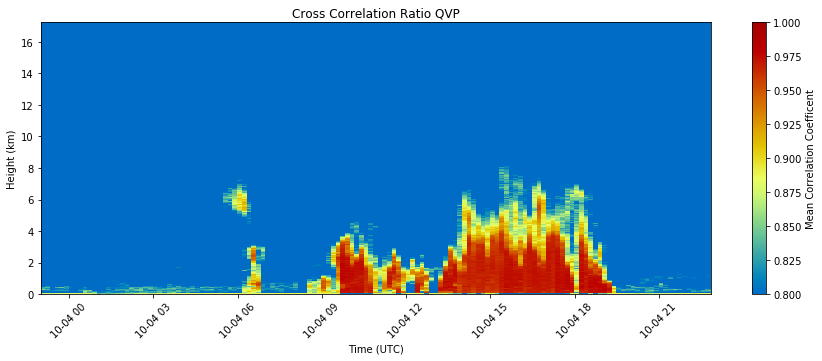

In [19]:
fig = plt.figure(figsize=[15,5])
ax = plt.gca()
#ax.xaxis_date()
cmap = pyart.graph.cm_colorblind.HomeyerRainbow
#for i in range(10):
    #Xq, Yq = np.meshgrid(new_time[i], new_height/1000)
    
    
img = plt.pcolormesh(new_time, new_height/1000, new_phv.transpose(), 
                     cmap=cmap, vmin=0.8, vmax=1)
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
#plt.ylim([0,17.5])
plt.xticks(rotation=45)
plt.title('Cross Correlation Ratio QVP')
cb = plt.colorbar(img, cmap=cmap)
cb.set_label('Mean Correlation Coefficent')
#plt.savefig('reflectivity.png', dpi=300)
plt.show()

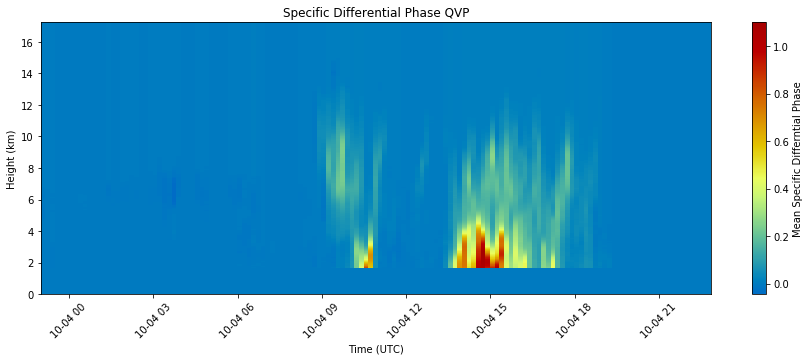

In [17]:
fig = plt.figure(figsize=[15,5])
ax = plt.gca()
#ax.xaxis_date()
cmap = pyart.graph.cm_colorblind.HomeyerRainbow
#for i in range(10):
    #Xq, Yq = np.meshgrid(new_time[i], new_height/1000)
    
    
img = plt.pcolormesh(new_time, new_height/1000, new_kdp.transpose(), 
                     cmap=cmap)#, vmin=0.5, vmax=1)
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
#plt.ylim([0,17.5])
plt.xticks(rotation=45)
plt.title('Specific Differential Phase QVP')
cb = plt.colorbar(img, cmap=cmap)
cb.set_label('Mean Specific Differntial Phase')
#plt.savefig('reflectivity.png', dpi=300)
plt.show()

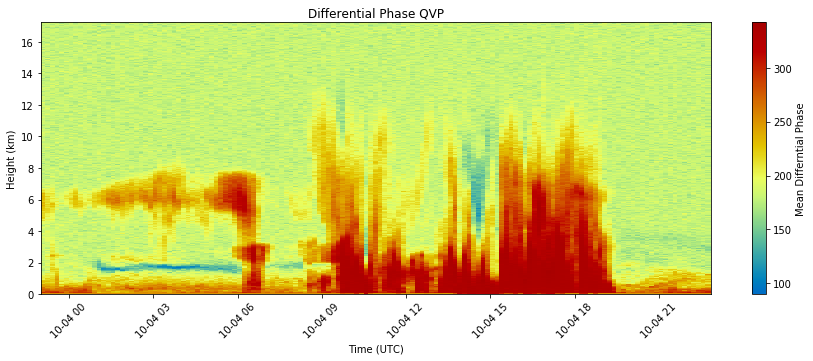

In [18]:
fig = plt.figure(figsize=[15,5])
ax = plt.gca()
#ax.xaxis_date()
cmap = pyart.graph.cm_colorblind.HomeyerRainbow
#for i in range(10):
    #Xq, Yq = np.meshgrid(new_time[i], new_height/1000)
    
    
img = plt.pcolormesh(new_time, new_height/1000, new_dp.transpose(), 
                     cmap=cmap)#, vmin=0.5, vmax=1)
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
#plt.ylim([0,17.5])
plt.xticks(rotation=45)
plt.title('Differential Phase QVP')
cb = plt.colorbar(img, cmap=cmap)
cb.set_label('Mean Differntial Phase')
#plt.savefig('reflectivity.png', dpi=300)
plt.show()